## Neural Network
In this exercise, we will use Neural Networks to perform Linear Regression.

The objective is to build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow using some of the higher-level wrappers (tf.estimators, tf.layers, tf.metrics, ...), you can check 'neural_network_raw' example for a raw, and more detailed TensorFlow implementation.

Further, we will use the MNIST Dataset used in the last exercise.

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Set the parameters.

In [2]:
learning_rate = 0.1
num_steps = 300
batch_size = 128

# Network Parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

Define the input function for training. **mnist.train.images**

In [3]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

Define the neural network.

In [5]:
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, num_classes)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

Define the model function (following __[TF Estimator Template](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator)__).

In [6]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

Build the Estimator.

In [7]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}


Train the Model.

In [8]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmptqzqeozt/model.ckpt.
INFO:tensorflow:loss = 2.57907, step = 1
INFO:tensorflow:global_step/sec: 242.443
INFO:tensorflow:loss = 0.503611, step = 101 (0.414 sec)
INFO:tensorflow:global_step/sec: 234.202
INFO:tensorflow:loss = 0.379899, step = 201 (0.426 sec)
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmptqzqeozt/model.ckpt.
INFO:tensorflow:Loss for final step: 0.373455.


Evaluate the Model (**mnist.test.images**). Define the input function for evaluating.

In [9]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-10-26-01:51:30
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmptqzqeozt/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-26-01:51:31
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.9058, global_step = 300, loss = 0.326552


{'accuracy': 0.90579998, 'global_step': 300, 'loss': 0.32655248}

We now test the prediction for 10000 images.

In [10]:
# Predict single images
n_images = 10000
# Get images from test set
test_images = mnist.test.images[:n_images]
test_labels = mnist.test.labels[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
y_list = list(test_labels)

# Display
correct_count = 0
for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
#     print("Model prediction:", preds[i])
#     print("true value:",y_list[i])
    if preds[i] == y_list[i]:
        correct_count += 1
        
print("Testing accuracy:", float(correct_count)/float(n_images))
        

INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmptqzqeozt/model.ckpt-300
Testing accuracy: 0.9058


## Q1. Plot training error and testing error vs steps 

For the same input settings, train and evaluate the model without regularization or dropout. Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.

In [13]:
# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.train.images}, y = mnist.train.labels,
    batch_size = batch_size, num_epochs = None, shuffle = True)

# Initialize lists
acc_train = []
acc_test = []

for step in list(range(5, num_steps + 1, 5)):
    # Build the estimator
    model = tf.estimator.Estimator(model_fn)
    
    # Train the model
    model.train(input_fn_train, steps = step)
    
    # training accuracy
    temp_train = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.train.images}, y = mnist.train.labels,
        batch_size = batch_size, shuffle = False)
    # Use the Estimator 'evaluate' method
    acc_train.append(model.evaluate(temp_train)["accuracy"])

    # test accuracy
    temp_test = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.test.images}, y = mnist.test.labels,
        batch_size = batch_size, shuffle = False)
    # Use the Estimator 'evaluate' method
    acc_test.append(model.evaluate(temp_test)["accuracy"])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpy11h08bx/model.ckpt.
INFO:tensorflow:loss = 2.61716, step = 1
INFO:tensorflow:Saving checkpoints for 5 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpy11h08bx/model.ckpt.
INFO:tensorflow:Loss for final step: 1.77694.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:53:18
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpy11h08bx/model.ckpt-5
INFO:tensorflow:Finished evaluation at 2017-10-26-01:53:19
INFO:tensorflow:Saving dict for global step 5: accuracy = 0.5036, global_step = 5, loss = 1.69066
INFO:tensorflow:Starting evaluation at 2017-10-26-01:53:20
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpy11h08bx/model.ckpt-5
INFO:tensorflow:Finished evaluation at 2017-10-26-01:

INFO:tensorflow:Saving dict for global step 30: accuracy = 0.7759, global_step = 30, loss = 0.78967
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpx3m0xvad/model.ckpt.
INFO:tensorflow:loss = 2.58694, step = 1
INFO:tensorflow:Saving checkpoints for 35 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpx3m0xvad/model.ckpt.
INFO:tensorflow:Loss for final step: 0.783352.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:53:47
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpx3m0xvad/model.ckpt-35
INFO:tensorflow:Finished evaluation at 2017-10-26-01:53:48
INFO:tensorflow:Saving dict for global step 35: accuracy = 0.791727, global_step = 35, loss = 0.761524
INFO:tensorflow:Starting evaluation at 2017-10-26-01:53:49
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v

INFO:tensorflow:Starting evaluation at 2017-10-26-01:54:12
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpuflqbgfz/model.ckpt-60
INFO:tensorflow:Finished evaluation at 2017-10-26-01:54:12
INFO:tensorflow:Saving dict for global step 60: accuracy = 0.8463, global_step = 60, loss = 0.524853
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6vv6z9fu/model.ckpt.
INFO:tensorflow:loss = 2.33805, step = 1
INFO:tensorflow:Saving checkpoints for 65 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6vv6z9fu/model.ckpt.
INFO:tensorflow:Loss for final step: 0.341803.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:54:15
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp6vv6z9fu/model.ckpt-65
INFO:tensorflow:Finished evaluation at 2017-10

INFO:tensorflow:Finished evaluation at 2017-10-26-01:54:40
INFO:tensorflow:Saving dict for global step 90: accuracy = 0.873673, global_step = 90, loss = 0.444335
INFO:tensorflow:Starting evaluation at 2017-10-26-01:54:41
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjx1wnrcl/model.ckpt-90
INFO:tensorflow:Finished evaluation at 2017-10-26-01:54:41
INFO:tensorflow:Saving dict for global step 90: accuracy = 0.8833, global_step = 90, loss = 0.418568
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmsp6dx1l/model.ckpt.
INFO:tensorflow:loss = 2.63416, step = 1
INFO:tensorflow:Saving checkpoints for 95 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmsp6dx1l/model.ckpt.
INFO:tensorflow:Loss for final step: 0.390242.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:54:44
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp3_rm0xqm/model.ckpt.
INFO:tensorflow:loss = 2.48518, step = 1
INFO:tensorflow:global_step/sec: 147.092
INFO:tensorflow:loss = 0.319556, step = 101 (0.681 sec)
INFO:tensorflow:Saving checkpoints for 120 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp3_rm0xqm/model.ckpt.
INFO:tensorflow:Loss for final step: 0.411105.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:55:09
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp3_rm0xqm/model.ckpt-120
INFO:tensorflow:Finished evaluation at 2017-10-26-01:55:11
INFO:tensorflow:Saving dict for global step 120: accuracy = 0.865909, global_step = 120, loss = 0.452119
INFO:tensorflow:Starting evaluation at 2017-10-26-01:55:11
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp3_rm0xqm/model.ckpt-120
INFO:tensorfl

INFO:tensorflow:Finished evaluation at 2017-10-26-01:55:37
INFO:tensorflow:Saving dict for global step 145: accuracy = 0.888327, global_step = 145, loss = 0.394833
INFO:tensorflow:Starting evaluation at 2017-10-26-01:55:38
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmppa2se9sh/model.ckpt-145
INFO:tensorflow:Finished evaluation at 2017-10-26-01:55:39
INFO:tensorflow:Saving dict for global step 145: accuracy = 0.8974, global_step = 145, loss = 0.372765
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpq7zmr5s2/model.ckpt.
INFO:tensorflow:loss = 2.45357, step = 1
INFO:tensorflow:global_step/sec: 135.523
INFO:tensorflow:loss = 0.43834, step = 101 (0.741 sec)
INFO:tensorflow:Saving checkpoints for 150 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpq7zmr5s2/model.ckpt.
INFO:

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpg3ky3fhp/model.ckpt.
INFO:tensorflow:loss = 2.38549, step = 1
INFO:tensorflow:global_step/sec: 143.29
INFO:tensorflow:loss = 0.351417, step = 101 (0.702 sec)
INFO:tensorflow:Saving checkpoints for 175 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpg3ky3fhp/model.ckpt.
INFO:tensorflow:Loss for final step: 0.509579.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:56:10
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpg3ky3fhp/model.ckpt-175
INFO:tensorflow:Finished evaluation at 2017-10-26-01:56:11
INFO:tensorflow:Saving dict for global step 175: accuracy = 0.888273, global_step = 175, loss = 0.38552
INFO:tensorflow:Starting evaluation at 2017-10-26-01:56:11
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_

INFO:tensorflow:Starting evaluation at 2017-10-26-01:56:39
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpsj_v11l_/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-10-26-01:56:41
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.889473, global_step = 200, loss = 0.385006
INFO:tensorflow:Starting evaluation at 2017-10-26-01:56:42
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpsj_v11l_/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-10-26-01:56:42
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.8947, global_step = 200, loss = 0.363187
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpmb17job2/model.ckpt.
INFO:tensorflow:loss = 2.41635, step = 1
INFO:tensorflow:global_step/sec: 119.025
INFO

INFO:tensorflow:Finished evaluation at 2017-10-26-01:57:17
INFO:tensorflow:Saving dict for global step 225: accuracy = 0.895255, global_step = 225, loss = 0.367275
INFO:tensorflow:Starting evaluation at 2017-10-26-01:57:17
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmppuejolqq/model.ckpt-225
INFO:tensorflow:Finished evaluation at 2017-10-26-01:57:18
INFO:tensorflow:Saving dict for global step 225: accuracy = 0.9049, global_step = 225, loss = 0.345403
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpr97w861g/model.ckpt.
INFO:tensorflow:loss = 2.54337, step = 1
INFO:tensorflow:global_step/sec: 120.13
INFO:tensorflow:loss = 0.398841, step = 101 (0.834 sec)
INFO:tensorflow:global_step/sec: 122.641
INFO:tensorflow:loss = 0.281903, step = 201 (0.815 sec)
INFO:tensorflow:Saving checkp

INFO:tensorflow:Starting evaluation at 2017-10-26-01:57:52
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmp1zqpro1b/model.ckpt-250
INFO:tensorflow:Finished evaluation at 2017-10-26-01:57:52
INFO:tensorflow:Saving dict for global step 250: accuracy = 0.9009, global_step = 250, loss = 0.350575
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpflqpwv28/model.ckpt.
INFO:tensorflow:loss = 2.4854, step = 1
INFO:tensorflow:global_step/sec: 86.1515
INFO:tensorflow:loss = 0.446985, step = 101 (1.162 sec)
INFO:tensorflow:global_step/sec: 79.9135
INFO:tensorflow:loss = 0.357427, step = 201 (1.254 sec)
INFO:tensorflow:Saving checkpoints for 255 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpflqpwv28/model.ckpt.
INFO:tensorflow:Loss for final step: 0.356229.
INFO:tensorflow:Starting 

INFO:tensorflow:Finished evaluation at 2017-10-26-01:58:31
INFO:tensorflow:Saving dict for global step 275: accuracy = 0.9057, global_step = 275, loss = 0.330421
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpusb_52o9/model.ckpt.
INFO:tensorflow:loss = 2.61197, step = 1
INFO:tensorflow:global_step/sec: 104.408
INFO:tensorflow:loss = 0.425692, step = 101 (0.959 sec)
INFO:tensorflow:global_step/sec: 95.2071
INFO:tensorflow:loss = 0.38411, step = 201 (1.050 sec)
INFO:tensorflow:Saving checkpoints for 280 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpusb_52o9/model.ckpt.
INFO:tensorflow:Loss for final step: 0.283891.
INFO:tensorflow:Starting evaluation at 2017-10-26-01:58:37
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpusb_52o9/model.ckpt-280
INFO:tensorflow:Finished 

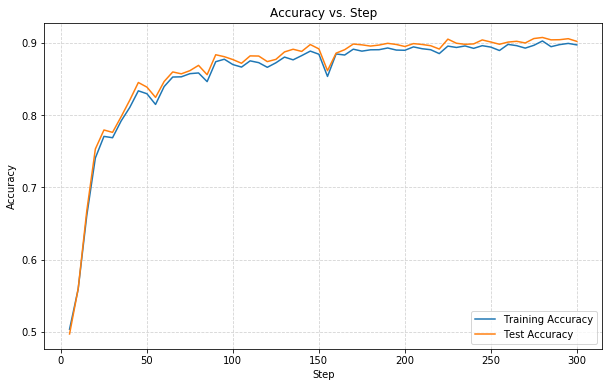

In [16]:
# Display the graph
fig, ax = plt.subplots(figsize = (10, 6))
X = list(range(5, num_steps + 1, 5))
plt.plot(X, acc_train, label = "Training Accuracy")
plt.plot(X, acc_test, label = "Test Accuracy")

plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Step')
plt.legend(loc = "lower right")
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

## Q2. Plot training error and testing error vs steps WITH regularization


For the same input settings, train and evaluate the model with regularization. 
By trial and error, choose a regularization parameter that improves the teset accuracy (change the architecture such as the number of layers and/or the number of nodes in th elayer, batch size, etc if you need to).
Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.


In [33]:
#------------------ Your code here -------------------#
learning_rate = 0.1
num_steps = 300
batch_size = 128
reg_constant = 0.01

# Network Parameters
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, num_classes)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

def model_fn_reg(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    weights = tf.Variable(
    tf.truncated_normal([num_input, num_classes]))
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    # https://stackoverflow.com/questions/37107223/how-to-add-regularizations-in-tensorflow
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32))) + reg_constant * tf.nn.l2_loss(weights)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the estimator
model = tf.estimator.Estimator(model_fn_reg)


# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

# Train the model
model.train(input_fn_train, steps = 200)

# test accuracy
temp_test = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)
# Use the Estimator 'evaluate' method
print(model.evaluate(temp_test)["accuracy"])
# -----------------------------------------------------#

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpo7k3ldli/model.ckpt.
INFO:tensorflow:loss = 32.6242, step = 1
INFO:tensorflow:global_step/sec: 290.427
INFO:tensorflow:loss = 25.1275, step = 101 (0.345 sec)
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpo7k3ldli/model.ckpt.
INFO:tensorflow:Loss for final step: 20.586.
INFO:tensorflow:Starting evaluation at 2017-10-26-03:00:16
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpo7k3ldli/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-10-26-03:00:16
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.8965, global_step = 200, loss = 20.6672
0.8965


In [34]:
# Build the estimator
model = tf.estimator.Estimator(model_fn)

# Training data
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

# Train the model
model.train(input_fn_train, steps = 200)

# test accuracy
temp_test = tf.estimator.inputs.numpy_input_fn(
    x = {'images': mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)
# Use the Estimator 'evaluate' method
print(model.evaluate(temp_test)["accuracy"])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjwh2ehp5/model.ckpt.
INFO:tensorflow:loss = 2.45849, step = 1
INFO:tensorflow:global_step/sec: 292.47
INFO:tensorflow:loss = 0.402488, step = 101 (0.343 sec)
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjwh2ehp5/model.ckpt.
INFO:tensorflow:Loss for final step: 0.331614.
INFO:tensorflow:Starting evaluation at 2017-10-26-03:00:23
INFO:tensorflow:Restoring parameters from /var/folders/l5/n8v_pkwx48s973m5yybpz4sc0000gn/T/tmpjwh2ehp5/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-10-26-03:00:23
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.8889, global_step = 200, loss = 0.382515
0.8889


## Q3. Plot training error and testing error vs steps with dropout


For the same input settings, train and evaluate the model with dropout but without regularization. 
Through trial-and-error find a dropout rate that improves the test accuracy (change the architecture such as the number of layers and/or the number of nodes in th elayer, batch size, etc if you need to).
Plot a graph with y axis being the training accuracy and test accuracy, and x-axis being the number of steps.